In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functions import *

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
df = pd.read_csv('online_sales_dataset.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Discount,PaymentMethod,ShippingCost,Category,SalesChannel,ReturnStatus,ShipmentProvider,WarehouseLocation,OrderPriority
0,221958,SKU_1964,White Mug,38,2020-01-01 00:00,1.71,37039.0,Australia,0.470000,Bank Transfer,10.79,Apparel,In-store,Not Returned,UPS,London,Medium
1,771155,SKU_1241,White Mug,18,2020-01-01 01:00,41.25,19144.0,Spain,0.190000,paypall,9.51,Electronics,Online,Not Returned,UPS,Rome,Medium
2,231932,SKU_1501,Headphones,49,2020-01-01 02:00,29.11,50472.0,Germany,0.350000,Bank Transfer,23.03,Electronics,Online,Returned,UPS,Berlin,High
3,465838,SKU_1760,Desk Lamp,14,2020-01-01 03:00,76.68,96586.0,Netherlands,0.140000,paypall,11.08,Accessories,Online,Not Returned,Royal Mail,Rome,Low
4,359178,SKU_1386,USB Cable,-30,2020-01-01 04:00,-68.11,NaN,United Kingdom,1.501433,Bank Transfer,NaN,Electronics,In-store,Not Returned,FedEx,NaN,Medium


In [40]:
df.shape

(49782, 17)

In [41]:
df.dtypes

InvoiceNo              int64
StockCode             object
Description           object
Quantity               int64
InvoiceDate           object
UnitPrice            float64
CustomerID           float64
Country               object
Discount             float64
PaymentMethod         object
ShippingCost         float64
Category              object
SalesChannel          object
ReturnStatus          object
ShipmentProvider      object
WarehouseLocation     object
OrderPriority         object
dtype: object

In [42]:
df.isnull().mean().sort_values()

InvoiceNo            0.000000
StockCode            0.000000
Description          0.000000
Quantity             0.000000
InvoiceDate          0.000000
UnitPrice            0.000000
Country              0.000000
Discount             0.000000
ShipmentProvider     0.000000
PaymentMethod        0.000000
Category             0.000000
SalesChannel         0.000000
ReturnStatus         0.000000
OrderPriority        0.000000
ShippingCost         0.049998
WarehouseLocation    0.070005
CustomerID           0.099996
dtype: float64

In [43]:
df[df.duplicated]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Discount,PaymentMethod,ShippingCost,Category,SalesChannel,ReturnStatus,ShipmentProvider,WarehouseLocation,OrderPriority


In [44]:
df.describe()

,InvoiceNo,Quantity,UnitPrice,CustomerID,Discount,ShippingCost
count,49782.000000,49782.000000,49782.000000,44804.000000,49782.000000,47293.000000
mean,550681.239946,22.372343,47.537862,55032.871775,0.275748,17.494529
std,260703.009944,17.917774,33.479510,25913.660157,0.230077,7.220557
min,100005.000000,-50.000000,-99.980000,10001.000000,0.000000,5.000000
25%,324543.000000,11.000000,23.592500,32750.750000,0.130000,11.220000
50%,552244.000000,23.000000,48.920000,55165.000000,0.260000,17.500000
75%,776364.000000,37.000000,74.610000,77306.250000,0.380000,23.720000
max,999997.000000,49.000000,100.000000,99998.000000,1.999764,30.000000


**Dealing null values (warehouse location and shipment cost)**

In [45]:
df['WarehouseLocation'].isnull().value_counts()

WarehouseLocation
False    46297
True      3485
Name: count, dtype: int64

In [46]:
df['ShippingCost'].isnull().value_counts()

ShippingCost
False    47293
True      2489
Name: count, dtype: int64

In [47]:
df.groupby(['Country'])['WarehouseLocation'].agg(pd.Series.mode)

Country
Australia              Rome
Belgium           Amsterdam
France                Paris
Germany               Paris
Italy                  Rome
Netherlands            Rome
Norway            Amsterdam
Portugal             London
Spain             Amsterdam
Sweden            Amsterdam
United Kingdom       Berlin
United States        Berlin
Name: WarehouseLocation, dtype: object

In [48]:
def fast_mode(df, key_cols, value_col):
    """ 
    Calculate a column mode, by group, ignoring null values. 

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame over which to calcualate the mode. 
    key_cols : list of str
        Columns to groupby for calculation of mode.
    value_col : str
        Column for which to calculate the mode. 

    Return
    ------ 
    pandas.DataFrame
        One row for the mode of value_col per key_cols group. If ties, 
        returns the one which is sorted first. 
    """
    return (df.groupby(key_cols + [value_col]).size() 
              .to_frame('counts').reset_index() 
              .sort_values('counts', ascending=False) 
              .drop_duplicates(subset=key_cols)).drop(columns='counts')

In [49]:
# replacing null values of warehouse location with mode values grouped by countries
print('Before: ', df['WarehouseLocation'].isnull().value_counts())
df.loc[df.WarehouseLocation.isnull(), 'WarehouseLocation'] = df.Country.map(fast_mode(df, ['Country'], 'WarehouseLocation').set_index('Country').WarehouseLocation)
print('\nAfter', df['WarehouseLocation'].isnull().value_counts())

Before:  WarehouseLocation
False    46297
True      3485
Name: count, dtype: int64

After WarehouseLocation
False    49782
Name: count, dtype: int64


In [50]:
# replacing null values of shipment cost by average cost grouped by countries and warehouse locations
print('Before: ', df['ShippingCost'].isnull().value_counts())
df['ShippingCost'] = df.groupby(['Country', 'WarehouseLocation'])['ShippingCost'].transform(lambda x: x.fillna(x.mean()))
print('\nAfter: ', df['ShippingCost'].isnull().value_counts())

Before:  ShippingCost
False    47293
True      2489
Name: count, dtype: int64

After:  ShippingCost
False    49782
Name: count, dtype: int64


**Checking for outlier(s)**

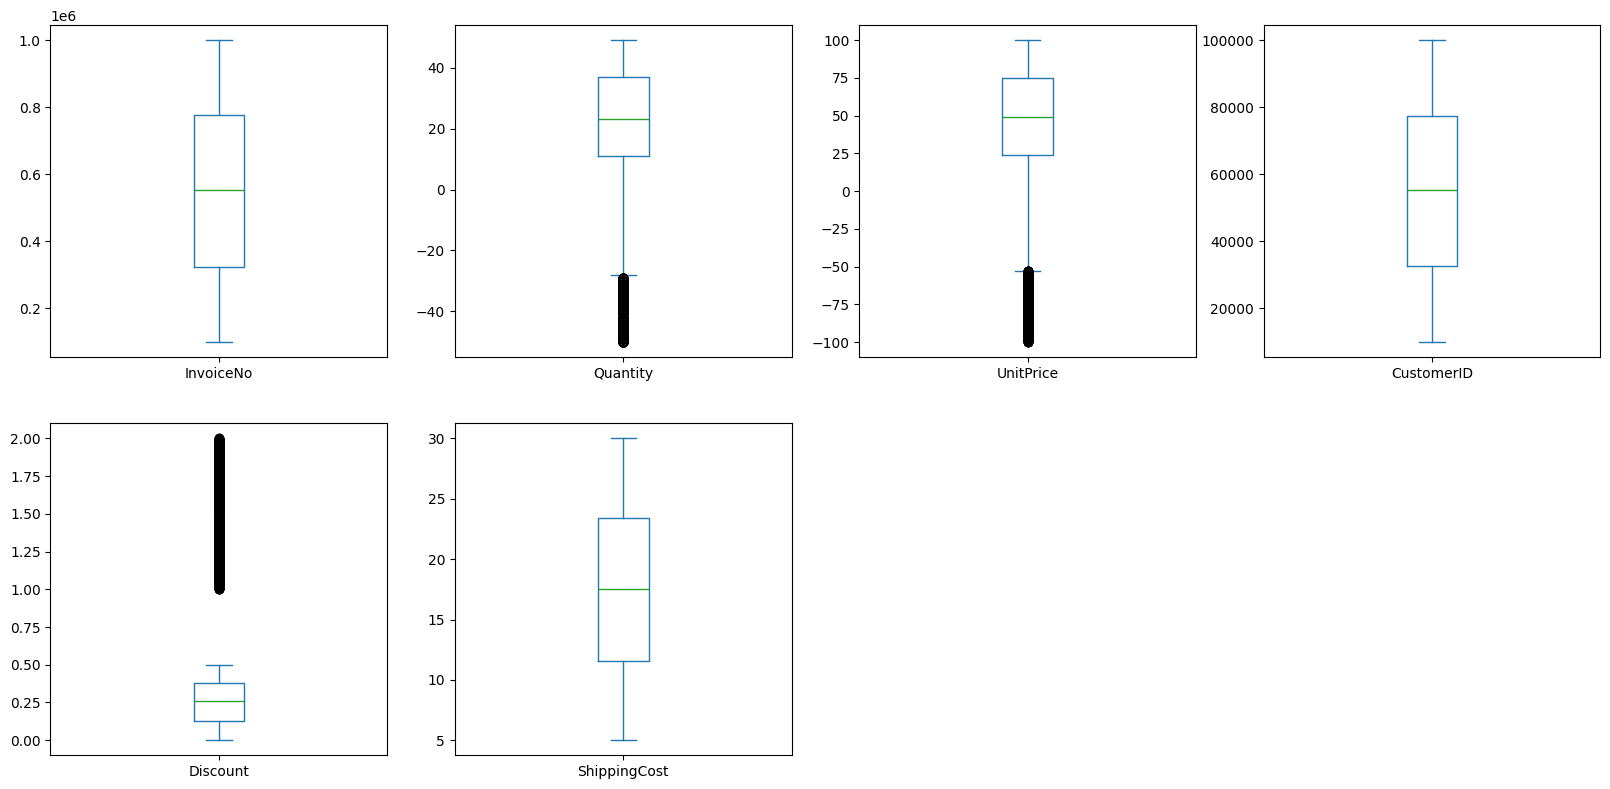

In [51]:
boxPlotAll(df)

**Remove abnormal entries (discount > 100%, quantity < 0, unit price < 0)**

In [52]:
abnormal_entries = df.index[(df["Discount"] > 1) | (df['Quantity'] < 0) | (df['UnitPrice'] < 0)]
print('Before: ', df.shape)
print('Abnormal entries: ', abnormal_entries.shape)
df = df.drop(abnormal_entries, axis=0)
print('After: ', df.shape)

Before:  (49782, 17)
Abnormal entries:  (2489,)
After:  (47293, 17)


**Rechecking distribution**

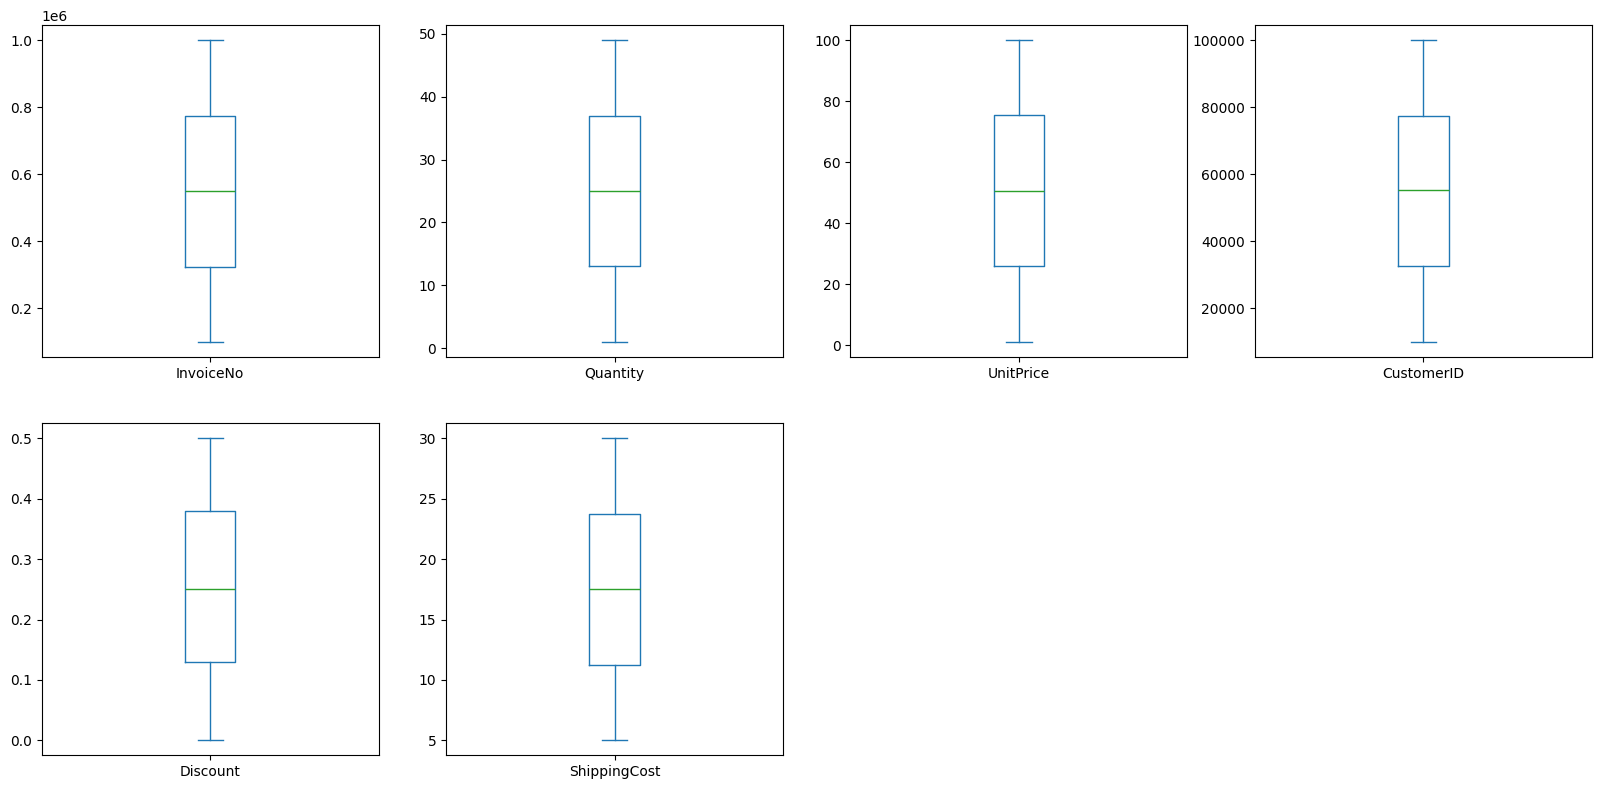

In [53]:
boxPlotAll(df)

In [54]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

**Checking qualitative features**

In [55]:
for feature in df.columns:
    if ((df[feature].dtype == object) & (feature != 'StockCode')):
        print(df[feature].value_counts())
        print('\n')

Description
Wall Clock        4362
USB Cable         4359
Backpack          4355
Desk Lamp         4338
White Mug         4318
Office Chair      4301
Headphones        4282
T-shirt           4268
Blue Pen          4264
Notebook          4230
Wireless Mouse    4216
Name: count, dtype: int64


Country
France            4021
Sweden            3994
United Kingdom    3973
Germany           3972
Belgium           3963
Portugal          3959
Netherlands       3957
Norway            3938
Spain             3897
Australia         3894
United States     3880
Italy             3845
Name: count, dtype: int64


PaymentMethod
Bank Transfer    15933
Credit Card      15721
paypall          15639
Name: count, dtype: int64


Category
Furniture      9577
Accessories    9454
Stationery     9446
Electronics    9433
Apparel        9383
Name: count, dtype: int64


SalesChannel
Online      23762
In-store    23531
Name: count, dtype: int64


ReturnStatus
Not Returned    42647
Returned         4646
Name: count, 

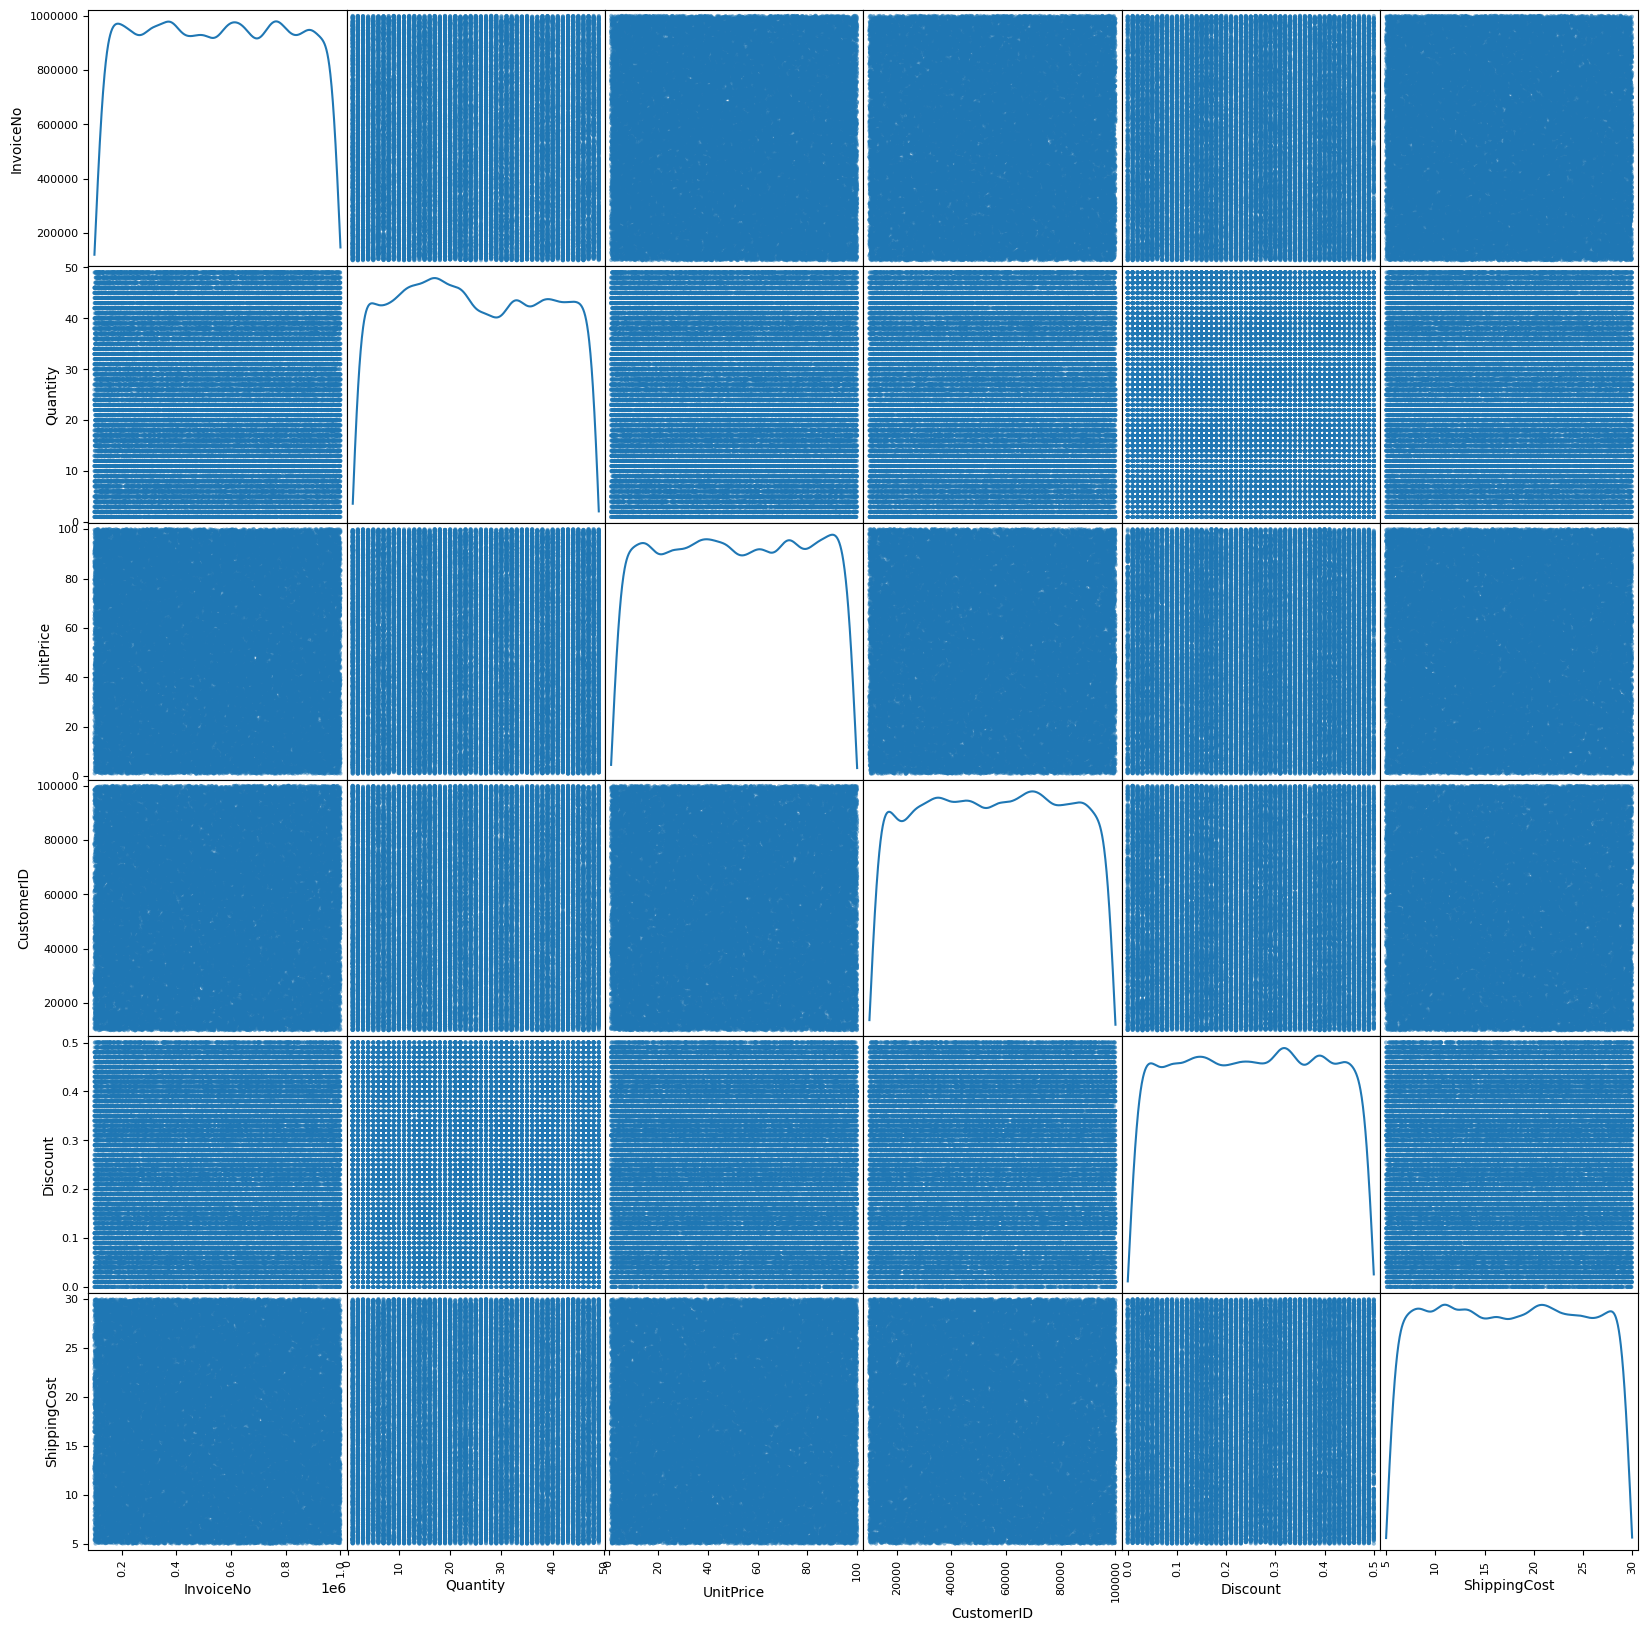

In [56]:
scatterMatrix(df)

In [57]:
# correlationMatrix(df)

**Feature Engineering**

In [58]:
df['Sales'] = df['Quantity'] * df['UnitPrice']

In [59]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Quarter'] = df['InvoiceDate'].dt.quarter

In [60]:
# target = df.index[df['Year'] > 2023]
# df = df.drop(target, axis=0)

In [61]:
binned = pd.cut(x=df['Discount'],
                bins=[df['Discount'].min(), df['Discount'].quantile(0.33), df['Discount'].quantile(0.66), df['Discount'].max()],
                labels=['L', 'M', 'H'])
df['Discount Level'] = binned

In [62]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Discount,PaymentMethod,...,SalesChannel,ReturnStatus,ShipmentProvider,WarehouseLocation,OrderPriority,Sales,Year,Month,Quarter,Discount Level
0,221958,SKU_1964,White Mug,38,2020-01-01 00:00:00,1.71,37039.0,Australia,0.47,Bank Transfer,...,In-store,Not Returned,UPS,London,Medium,64.98,2020,1,1,H
1,771155,SKU_1241,White Mug,18,2020-01-01 01:00:00,41.25,19144.0,Spain,0.19,paypall,...,Online,Not Returned,UPS,Rome,Medium,742.50,2020,1,1,M
2,231932,SKU_1501,Headphones,49,2020-01-01 02:00:00,29.11,50472.0,Germany,0.35,Bank Transfer,...,Online,Returned,UPS,Berlin,High,1426.39,2020,1,1,H
3,465838,SKU_1760,Desk Lamp,14,2020-01-01 03:00:00,76.68,96586.0,Netherlands,0.14,paypall,...,Online,Not Returned,Royal Mail,Rome,Low,1073.52,2020,1,1,L
5,744167,SKU_1006,Office Chair,47,2020-01-01 05:00:00,70.16,53887.0,Sweden,0.48,Credit Card,...,Online,Not Returned,DHL,London,Medium,3297.52,2020,1,1,H


In [63]:
pd.DataFrame(df.groupby(['Country', 'Category'])['Sales'].mean().sort_values(ascending=False))

Sales
Country        Category                
Norway         Electronics  1342.275370
United States  Electronics  1339.673791
               Apparel      1332.328479
United Kingdom Accessories  1324.604655
Spain          Furniture    1314.422370
Germany        Furniture    1313.041745
Belgium        Apparel      1306.822602
United States  Accessories  1304.682471
Italy          Stationery   1300.594669
France         Furniture    1300.391630
Belgium        Electronics  1297.635358
Portugal       Apparel      1294.756654
United Kingdom Electronics  1291.506645
Belgium        Accessories  1289.080531
Sweden         Accessories  1282.102547
Italy          Accessories  1280.064013
Portugal       Furniture    1279.846348
United States  Furniture    1279.629037
Spain          Stationery   1278.758593
               Apparel      1277.578043
United Kingdom Apparel      1272.185631
Netherlands    Apparel      1271.892610
France         Apparel      1271.857542
Germany        Stationery   1271.034037
               Accessories  1261.497785
Sweden         Stationery   1260.963646
               Apparel      1260.506354
Belgium        Stationery   1257.624037
Germany        Electronics  1256.812385
Australia      Stationery   1253.393239
Norway         Accessories  1252.097550
Italy          Furniture    1251.654744
United Kingdom Stationery   1249.487055
Australia      Furniture    1248.414107
Belgium        Furniture    1248.176037
Italy          Apparel      1246.816247
Australia      Accessories  1245.919265
Sweden         Electronics  1245.595427
Spain          Accessories  1243.073735
Portugal       Stationery   1242.849798
Italy          Electronics  1242.454980
United States  Stationery   1239.295132
Sweden         Furniture    1237.901002
France         Accessories  1234.578785
Australia      Electronics  1234.044221
United Kingdom Furniture    1232.392154
France         Stationery   1229.260315
Germany        Apparel      1227.848679
Portugal       Accessories  1225.424636
Norway         Stationery   1225.213739
Spain          Electronics  1224.435410
Netherlands    Furniture    1222.623354
Portugal       Electronics  1221.999685
Netherlands    Stationery   1219.813772
Norway         Apparel      1214.478657
Netherlands    Accessories  1195.477636
Australia      Apparel      1193.995219
France         Electronics  1186.166875
Norway         Furniture    1183.173066
Netherlands    Electronics  1173.153926

**Sales Trend**

In [64]:
def create_df(input_df, target_feature):
    """
    Function to create df of sales group by different features such as year, quarter and month
    Input: Original complete df, target group eature such as year and sales channel
    Output: Sales df grouped by target feature containing average, median and total sales
    Return: Sales df
    """
    output_df = pd.DataFrame(columns=[target_feature, 'Average Sales', 'Median Sales', 'Total Sales'])
    output_df[target_feature] = df[target_feature].unique()
    output_df['Average Sales'] = list(df.groupby([target_feature])['Sales'].mean())
    output_df['Median Sales'] = list(df.groupby([target_feature])['Sales'].median())
    output_df['Total Sales'] = list(df.groupby([target_feature])['Sales'].sum())

    return output_df

In [65]:
def plot_sales_graph(input_df, height=8, width=3, rotation_degree=0):
    """
    Function to plot the charts of sales vs target feature (1st column as index) such as year and sales channel
    Input: grouped df
    Output: 2 charts of average, median and total sales vs target feature
    Return: None
    """
    input_df.index = input_df[input_df.columns[0]]
    fig = plt.figure(figsize=(height, width))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(input_df.index, input_df[['Average Sales', 'Median Sales']])
    ax1.set_title(input_df.columns[0])
    ax1.set_xticks(input_df.index)
    ax1.tick_params('x', labelrotation=rotation_degree)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(input_df.index, input_df[['Total Sales']])
    ax2.set_xticks(input_df.index)
    ax2.tick_params('x', labelrotation=rotation_degree)

    fig.tight_layout()
    fig.show()

Sales by time

In [66]:
df_sales_year = create_df(df, 'Year')
df_sales_quarter = create_df(df, 'Quarter')
df_sales_month = create_df(df, 'Month')

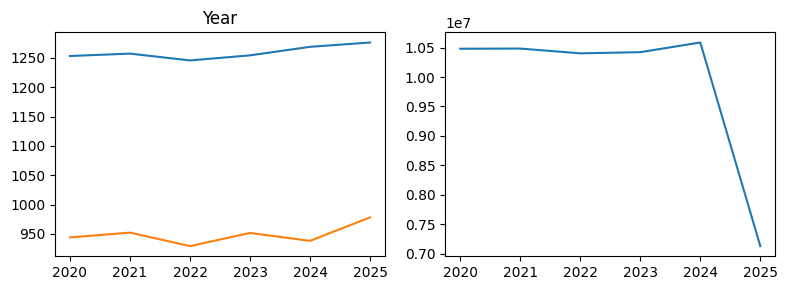

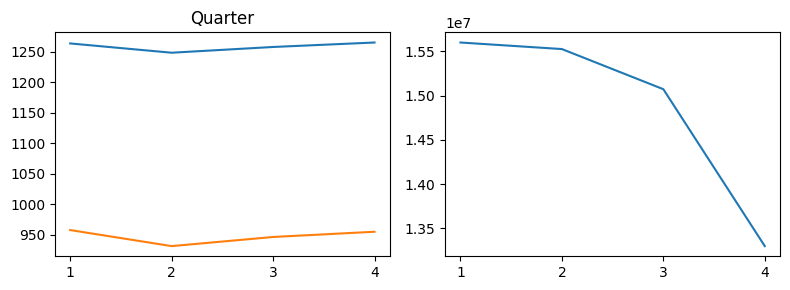

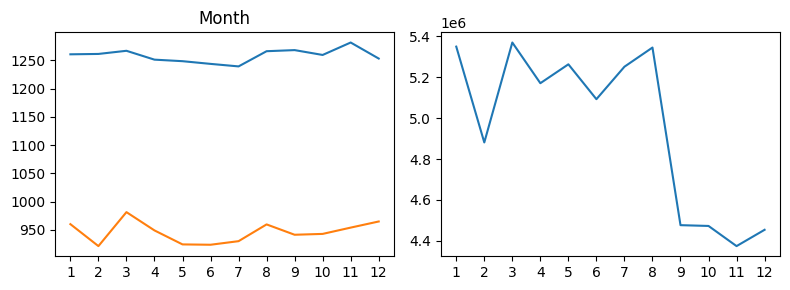

In [67]:
df_sales = [df_sales_year, df_sales_quarter, df_sales_month]
for entry in df_sales:
    plot_sales_graph(entry)

Sales by sales channel

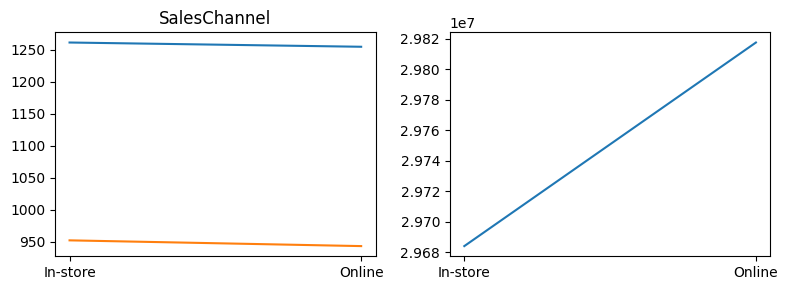

In [68]:
df_saleschannel = create_df(df, 'SalesChannel')
plot_sales_graph(df_saleschannel)

<Axes: xlabel='SalesChannel', ylabel='Sales'>

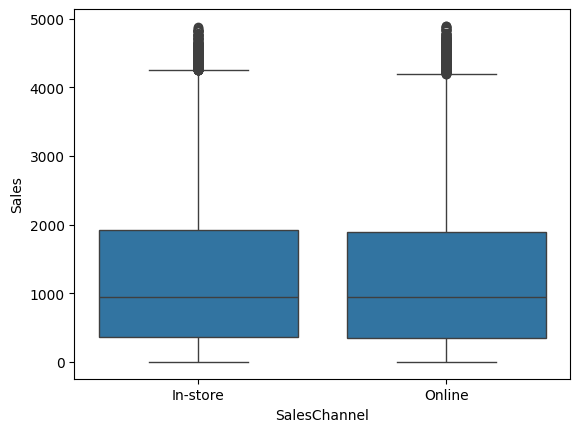

In [69]:
sns.boxplot(x=df['SalesChannel'], y=df['Sales'])

Sales by product

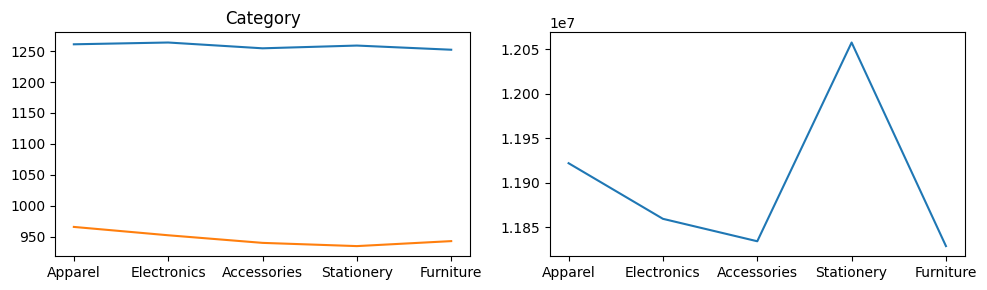

In [70]:
df_productcategory = create_df(df, 'Category')
plot_sales_graph(df_productcategory, 10)

<Axes: xlabel='Category', ylabel='Sales'>

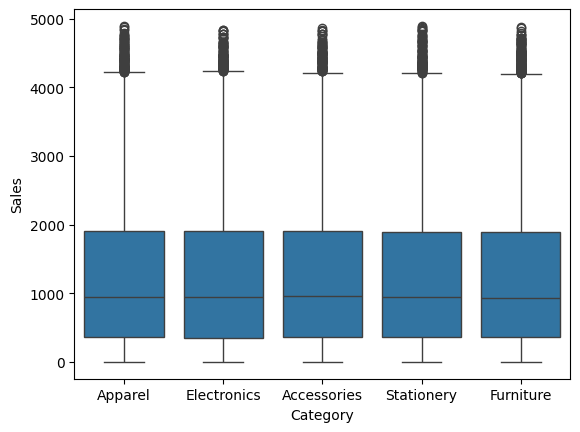

In [71]:
sns.boxplot(x=df['Category'], y=df['Sales'])

Sales by country

<Axes: xlabel='Country', ylabel='Sales'>

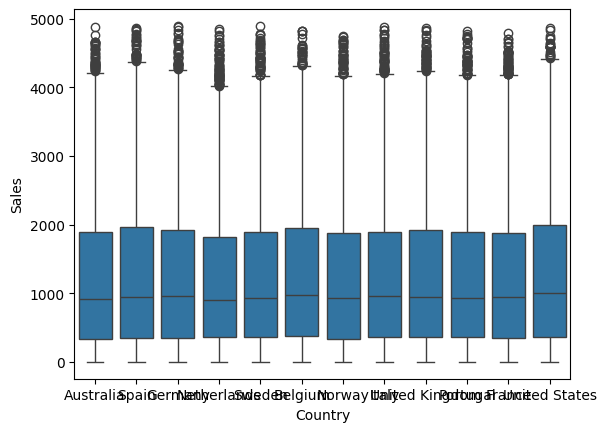

In [72]:
sns.boxplot(x=df['Country'], y=df['Sales'])

**Customer Behavior**

Check discount vs sales distribution

(array([4242., 4701., 5662., 3766., 4714., 5609., 4877., 3813., 4705.,
        5204.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
 <BarContainer object of 10 artists>)

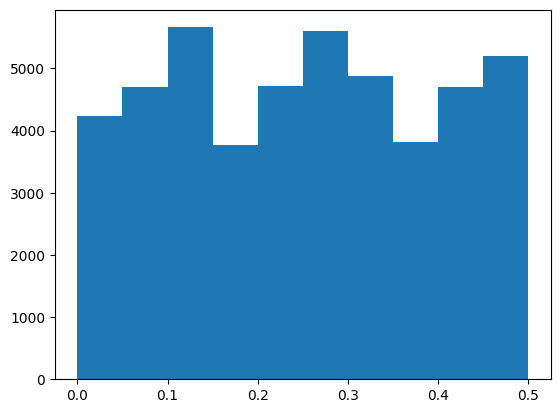

In [73]:
plt.hist(df['Discount'])

<Axes: xlabel='Discount Level', ylabel='Sales'>

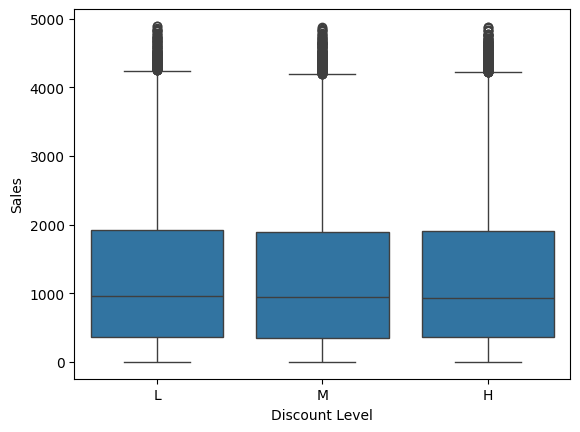

In [74]:
sns.boxplot(x=df['Discount Level'], y=df['Sales'])

Customer distribution by country

([<matplotlib.patches.Wedge at 0x152da7d7c90>,
 [Text(1.0632270896214633, 0.28204282634924993, 'Australia'),
  Text(0.7810829315284181, 0.7745382198929712, 'Belgium'),
  Text(0.28189365978763536, 1.0632666479164732, 'France'),
  Text(-0.296107917255495, 1.059396102191533, 'Germany'),
  Text(-0.7827646909090735, 0.7728385592515573, 'Italy'),
  Text(-1.0628901884108912, 0.2833098081250639, 'Netherlands'),
  Text(-1.061628136155453, -0.2880029522819153, 'Norway'),
  Text(-0.7743188539238003, -0.781300398347609, 'Portugal'),
  Text(-0.28144585639327935, -1.06338526880856, 'Spain'),
  Text(0.28822661663214433, -1.0615674342521944, 'Sweden'),
  Text(0.7824938495930228, -0.773112783071844, 'United Kingdom'),
  Text(1.0633853146618963, -0.28144568314582497, 'United States')])

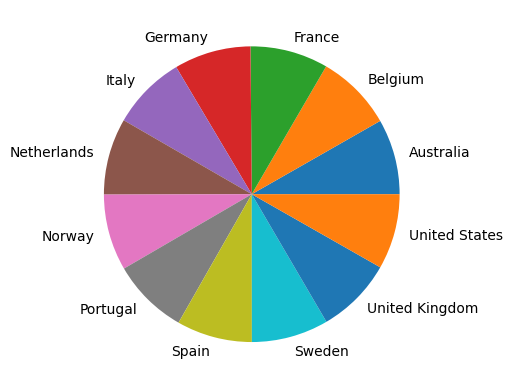

In [ ]:
df_country = df.groupby(['Country'])['CustomerID'].count().reset_index()
plt.pie(labels=df_country['Country'], x=df_country['CustomerID'])

Sales by payment method

C:\Users\1\AppData\Local\Temp\ipykernel_20844\1403780566.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


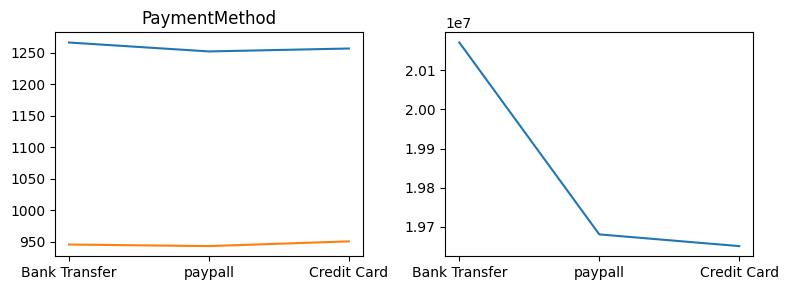

In [225]:
df_paymentmethod = create_df(df, 'PaymentMethod')
plot_sales_graph(df_paymentmethod)

<Axes: xlabel='PaymentMethod', ylabel='Sales'>

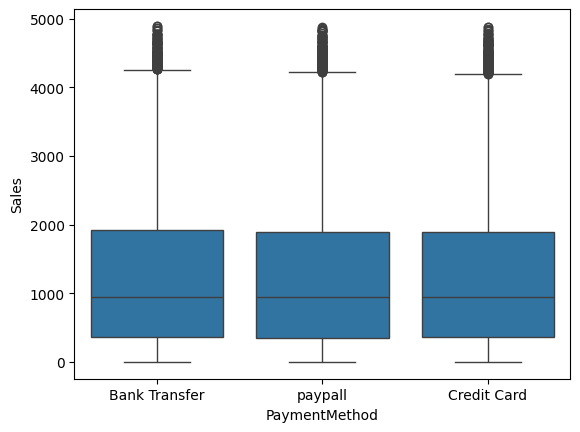

In [81]:
sns.boxplot(x=df['PaymentMethod'], y=df['Sales'])

**Order Management**

Shipping cost by shipping provider

Sales by Country/Warehouse Location

C:\Users\1\AppData\Local\Temp\ipykernel_20844\3707338460.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


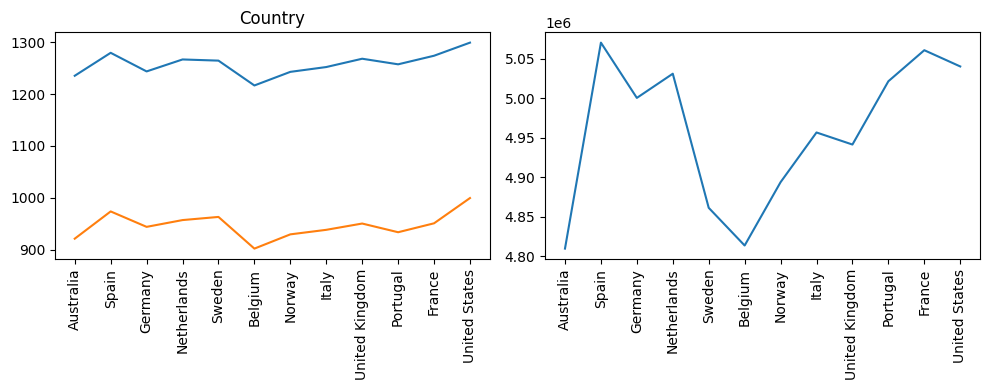

In [242]:
df_sales_country = create_df(df, 'Country')
plot_sales_graph(df_sales_country, 10, 4, 90)

<Axes: xlabel='Country', ylabel='Sales'>

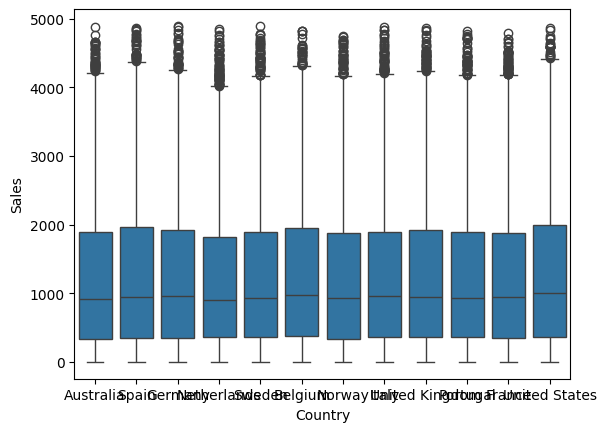

In [82]:
sns.boxplot(x=df['Country'], y=df['Sales'])

<Axes: xlabel='WarehouseLocation', ylabel='Sales'>

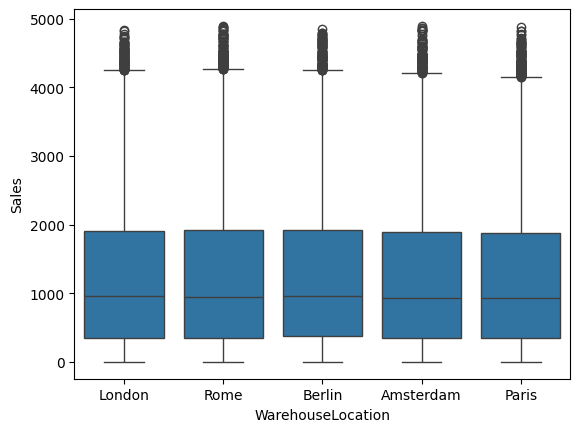

In [83]:
sns.boxplot(x=df['WarehouseLocation'], y=df['Sales'])

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA